# Pilot Analyses -- Psifr Edition

## Setup

In [1]:
# %% Dependencies
# import os
# new_dr = "/Users/roberttornatore/Desktop/JATOS/study_assets_root/online_experiments"
# os.chdir(new_dr)
# print(os.getcwd())
from experiments.block_cat.helpers import load_data
from psifr import fr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
def get_trial_category_labels(
    category_cues: np.ndarray,
    pres_categoryids: np.ndarray,
) -> list[str]:
    """
    Determine trial category labels ("block", "isolate", "control") based on 
    how many times the cued category appears in the presented categories.

    Args:
        category_cues (np.ndarray): shape [n_trials, 1], category ID cue for each trial
        pres_categoryids (np.ndarray): shape [n_trials, n_items], category ID for each study item

    Returns:
        list[str]: one label per trial
    """
    labels = []
    for cue_cat, pres_cats in zip(category_cues[:, 0], pres_categoryids):
        matches = np.sum(pres_cats == cue_cat)
        if matches == 0:
            label = "control"
        elif matches == 1:
            label = "isolate"
        else:
            label = "block"
        labels.append(label)
    return labels

def get_block_success_group(
    target_success: np.ndarray,
    cue_type: list[str],
    recalls: np.ndarray,
) -> list[int]:
    """
    Returns a trial-level feature:
    - 0 if not a successful block-cue targeting trial
    - 1 if first recalled item was studied in position 4-6
    - 2 if first recalled item was studied in position 10-12
    """

    labels = []
    for success, cue, recall_positions in zip(target_success[:, 0], cue_type, recalls):
        if not (success and cue == "block"):
            labels.append(0)
            continue

        first_pos = next((pos for pos in recall_positions if pos > 0), 0)
        if first_pos in [4, 5, 6]:
            labels.append(1)
        elif first_pos in [10, 11, 12]:
            labels.append(2)
        else:
            labels.append(0)

    return labels

def export_to_psifr_long_table(data: dict[str, np.ndarray]) -> pd.DataFrame:
    """Convert data in EMBAM format to long table psifr format.

    Args:
        data (dict[str, np.ndarray]): Data in EMBAM format. In EMBAM format, data is stored
        in a dictionary where each key corresponds to a different variable. The values are
        2-D numpy arrays where each row corresponds to a trial. Required fields in the EMBAM
        format are: 'subject', 'listLength', 'pres_itemnos', 'recalls'. Additional fields
        such as 'condition', 'pres_itemids', and 'rec_itemids' can identify details about
        the trial or each presented or recalled item.

    Returns:
        pd.DataFrame: A pandas DataFrame whose rows correspond to a single study or recall
        event. The required fields in each row are 'subject', 'list', 'trial_type', 'position',
        and 'item'. Additional fields can be included to describe events, e.g., 'condition'.
    """
    events = {
        "subject": [],
        "list": [],
        "trial_type": [],
        "position": [],
        "item": [],
        "condition": [],
        "target_success": [],
        "listLength": [],
        "trial_category_cue": [],
        "category": [],
        "cue_type": [],
        "block_success_group": [],
    }

    # precompute per-trial cue labels to reuse for both study and recall events
    trial_labels = get_trial_category_labels(
        data["category_cues"],
        data["pres_categoryids"],
    )
    block_success_group = get_block_success_group(
        data["target_success"],
        trial_labels,
        data['recalls'],
    )

    # first all study events
    for trial_index, trial in enumerate(data["pres_itemids"]):
        for study_index, item in enumerate(trial):
            if item == 0:
                continue
            events["subject"].append(data["subject"][trial_index][0])
            events["list"].append(data["block"][trial_index][0])
            events["trial_type"].append("study")
            events["position"].append(study_index + 1)
            events["item"].append(item)
            events["condition"].append(data["condition"][trial_index][0])
            events["target_success"].append(data["target_success"][trial_index][0])
            events["listLength"].append(data["listLength"][trial_index][0])
            events["trial_category_cue"].append(data["category_cues"][trial_index][0])
            events["category"].append(
                data["pres_categoryids"][trial_index, study_index]
            )
            events["cue_type"].append(trial_labels[trial_index])
            events["block_success_group"].append(block_success_group[trial_index])

    # then all recall events
    for trial_index, trial in enumerate(data["rec_itemids"]):
        for recall_index, item in enumerate(trial):
            if item == 0:
                continue
            events["subject"].append(data["subject"][trial_index][0])
            events["list"].append(data["block"][trial_index][0])
            events["trial_type"].append("recall")
            events["position"].append(recall_index + 1)
            events["item"].append(item)
            events["condition"].append(data["condition"][trial_index][0])
            events["target_success"].append(data["target_success"][trial_index][0])
            events["listLength"].append(data["listLength"][trial_index][0])
            events["trial_category_cue"].append(data["category_cues"][trial_index][0])
            events["category"].append(
                data["rec_categoryids"][trial_index, recall_index]
            )
            events["cue_type"].append(trial_labels[trial_index])
            events["block_success_group"].append(block_success_group[trial_index])

    return pd.DataFrame.from_dict(events)


In [3]:
# %% Load data
embam_data_path = "experiments/block_cat/expt_block_cat.h5"
embam_data = load_data(embam_data_path)
events = export_to_psifr_long_table(embam_data)
events.head()



,subject,list,trial_type,position,item,condition,target_success,listLength,trial_category_cue,category,cue_type,block_success_group
0,0,1,study,1,159,2,True,15,24,9,block,2
1,0,1,study,2,451,2,True,15,24,26,block,2
2,0,1,study,3,387,2,True,15,24,23,block,2
3,0,1,study,4,416,2,True,15,24,24,block,2
4,0,1,study,5,410,2,True,15,24,24,block,2


In [4]:
# %% Merge study and recall events
data = fr.merge_free_recall(
    events,
    list_keys=[
        "condition",
        "target_success",
        "listLength",
        "trial_category_cue",
        "category",
        "cue_type",
        "block_success_group",
    ],
)

data

,subject,list,item,input,output,study,recall,repeat,intrusion,condition,target_success,listLength,trial_category_cue,category,cue_type,block_success_group,prior_list,prior_input
2,0,1,159,1,NaN,True,False,0,False,2,True,15,24,9,block,2,NaN,NaN
13,0,1,451,2,NaN,True,False,0,False,2,True,15,24,26,block,2,NaN,NaN
6,0,1,387,3,NaN,True,False,0,False,2,True,15,24,23,block,2,NaN,NaN
11,0,1,416,4,NaN,True,False,0,False,2,True,15,24,24,block,2,NaN,NaN
9,0,1,410,5,NaN,True,False,0,False,2,True,15,24,24,block,2,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1846,7,15,542,11,NaN,True,False,0,False,2,True,15,31,31,block,2,NaN,NaN
1845,7,15,540,12,1.0,True,True,0,False,2,True,15,31,31,block,2,NaN,NaN
1835,7,15,121,13,3.0,True,True,0,False,2,True,15,31,7,block,2,NaN,NaN
1837,7,15,327,14,NaN,True,False,0,False,2,True,15,31,19,block,2,NaN,NaN


## Demo Analyses

### Probability of First and Second Recall

#### Isolates

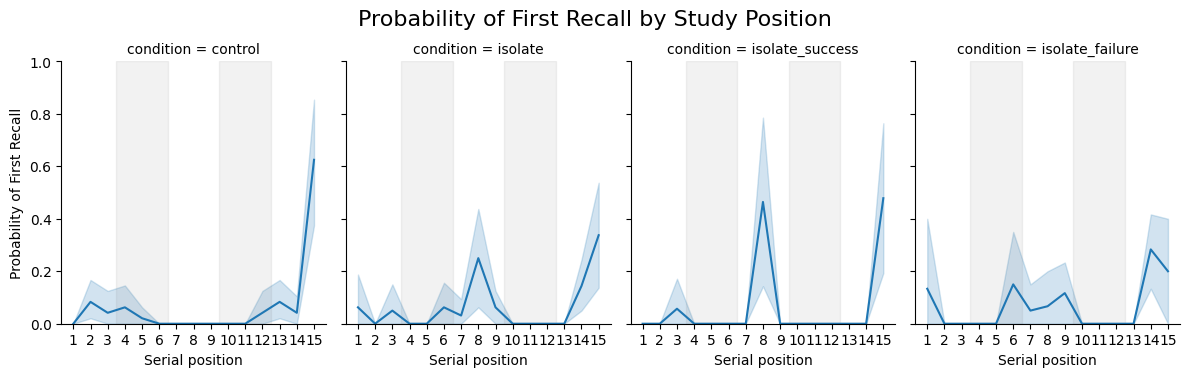

In [5]:
# %% PFR

pnr_control = fr.pnr(data.query('cue_type == "control"'))
# pnr_block = fr.pnr(data.query('cue_type == "block"'))
# pnr_block_success = fr.pnr(data.query('block_success_group > 0'))
# pnr_block1_success = fr.pnr(data.query('block_success_group == 1'))
# pnr_block2_success = fr.pnr(data.query('block_success_group == 2'))
pnr_isolate = fr.pnr(data.query('cue_type == "isolate"'))
pnr_isolate_success = fr.pnr(data.query('cue_type == "isolate" and target_success == 1'))
pnr_isolate_failure = fr.pnr(data.query('cue_type == "isolate" and target_success == 0'))

pnr = pd.concat(
    [
        pnr_control.assign(condition="control"),
        # pnr_block.assign(condition="block"),
        # pnr_block_success.assign(condition="block_success"),
        # pnr_block1_success.assign(condition="block1_success"),
        # pnr_block2_success.assign(condition="block2_success"),
        pnr_isolate.assign(condition="isolate"),
        pnr_isolate_success.assign(condition="isolate_success"),
        pnr_isolate_failure.assign(condition="isolate_failure"),
    ]
)

# Limit to first recall
pfr = pnr.query("output <= 1")

# Plotting
# g = fr.plot_spc(pfr)
# plt.ylim([0, 0.6])
# g = fr.plot_spc(pfr, col="subject", col_wrap=3)
# plt.ylim([0, 0.6])
g = fr.plot_spc(pfr, col="condition", col_wrap=4)
# set g size bigger
g.fig.set_size_inches(12, 4)

# show all 15 positions in xticks
plt.xticks(
    np.arange(1, 16),
    [str(i) for i in range(1, 16)],
)


g.set_ylabels("Probability of First Recall")

# for each figure, draw vertical lines at 4, 6, 10, 12
for ax in g.axes.flat:
    ax.set_xticks(np.arange(1, 16))
    ax.set_xticklabels([str(i) for i in range(1, 16)])
    
    # Early block: positions 4 to 6
    ax.axvspan(3.5, 6.5, color="gray", alpha=0.1)  # extend slightly beyond edges
    
    # Late block: positions 10 to 12
    ax.axvspan(9.5, 12.5, color="gray", alpha=0.1)

g.fig.suptitle("Probability of First Recall by Study Position", fontsize=16)

# Adjust layout to make space for the title
g.fig.subplots_adjust(top=0.85)

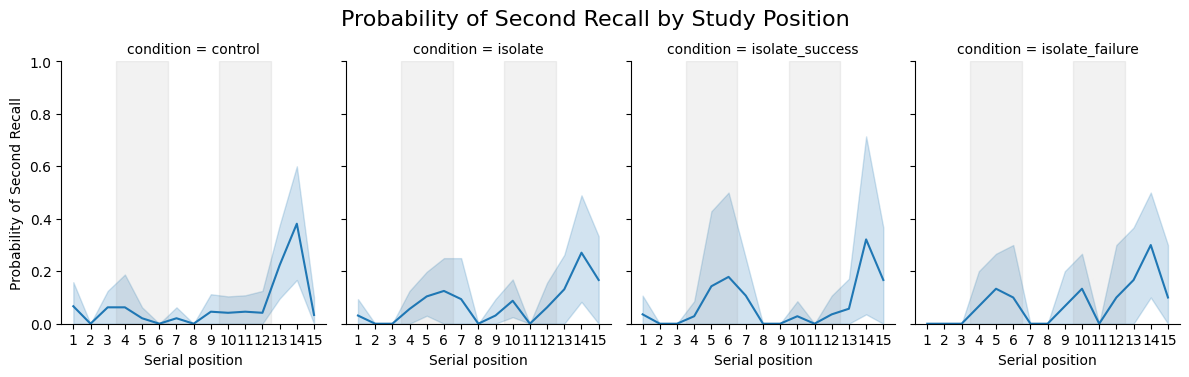

In [6]:
# %% P2R

# Limit to first recall
p2r = pnr.query("output == 2")

# Plotting
# g = fr.plot_spc(p2r)
# plt.ylim([0, 0.7])
# g = fr.plot_spc(p2r, col="subject", col_wrap=5)
# plt.ylim([0, 0.7])
g = fr.plot_spc(p2r, col="condition", col_wrap=4)

# set g size bigger
g.fig.set_size_inches(12, 4)

# show all 15 positions in xticks
plt.xticks(
    np.arange(1, 16),
    [str(i) for i in range(1, 16)],
)

g.set_ylabels("Probability of Second Recall")

# for each figure, draw vertical lines at 4, 6, 10, 12
for ax in g.axes.flat:
    ax.set_xticks(np.arange(1, 16))
    ax.set_xticklabels([str(i) for i in range(1, 16)])
    
    # Early block: positions 4 to 6
    ax.axvspan(3.5, 6.5, color="gray", alpha=0.1)  # extend slightly beyond edges
    
    # Late block: positions 10 to 12
    ax.axvspan(9.5, 12.5, color="gray", alpha=0.1)

g.fig.suptitle("Probability of Second Recall by Study Position", fontsize=16)

# Adjust layout to make space for the title
g.fig.subplots_adjust(top=0.85)

#### Block-Cued

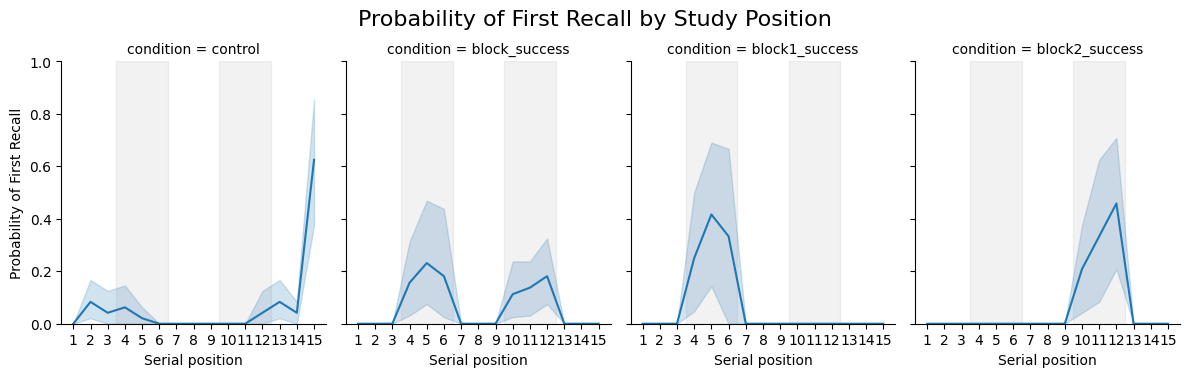

In [7]:
# %% PFR

pnr_control = fr.pnr(data.query('cue_type == "control"'))
# pnr_block = fr.pnr(data.query('cue_type == "block"'))
pnr_block_success = fr.pnr(data.query('block_success_group > 0'))
pnr_block1_success = fr.pnr(data.query('block_success_group == 1'))
pnr_block2_success = fr.pnr(data.query('block_success_group == 2'))
# pnr_isolate = fr.pnr(data.query('cue_type == "isolate"'))
# pnr_isolate_success = fr.pnr(data.query('cue_type == "isolate" and target_success == 1'))
# pnr_isolate_failure = fr.pnr(data.query('cue_type == "isolate" and target_success == 0'))

pnr = pd.concat(
    [
        pnr_control.assign(condition="control"),
        # pnr_block.assign(condition="block"),
        pnr_block_success.assign(condition="block_success"),
        pnr_block1_success.assign(condition="block1_success"),
        pnr_block2_success.assign(condition="block2_success"),
        # pnr_isolate.assign(condition="isolate"),
        # pnr_isolate_success.assign(condition="isolate_success"),
        # pnr_isolate_failure.assign(condition="isolate_failure"),
    ]
)

# Limit to first recall
pfr = pnr.query("output <= 1")

# Plotting
# g = fr.plot_spc(pfr)
# plt.ylim([0, 0.6])
# g = fr.plot_spc(pfr, col="subject", col_wrap=3)
# plt.ylim([0, 0.6])
g = fr.plot_spc(pfr, col="condition", col_wrap=4)
# set g size bigger
g.fig.set_size_inches(12, 4)

# show all 15 positions in xticks
plt.xticks(
    np.arange(1, 16),
    [str(i) for i in range(1, 16)],
)


g.set_ylabels("Probability of First Recall")

# for each figure, draw vertical lines at 4, 6, 10, 12
for ax in g.axes.flat:
    ax.set_xticks(np.arange(1, 16))
    ax.set_xticklabels([str(i) for i in range(1, 16)])
    
    # Early block: positions 4 to 6
    ax.axvspan(3.5, 6.5, color="gray", alpha=0.1)  # extend slightly beyond edges
    
    # Late block: positions 10 to 12
    ax.axvspan(9.5, 12.5, color="gray", alpha=0.1)

g.fig.suptitle("Probability of First Recall by Study Position", fontsize=16)

# Adjust layout to make space for the title
g.fig.subplots_adjust(top=0.85)

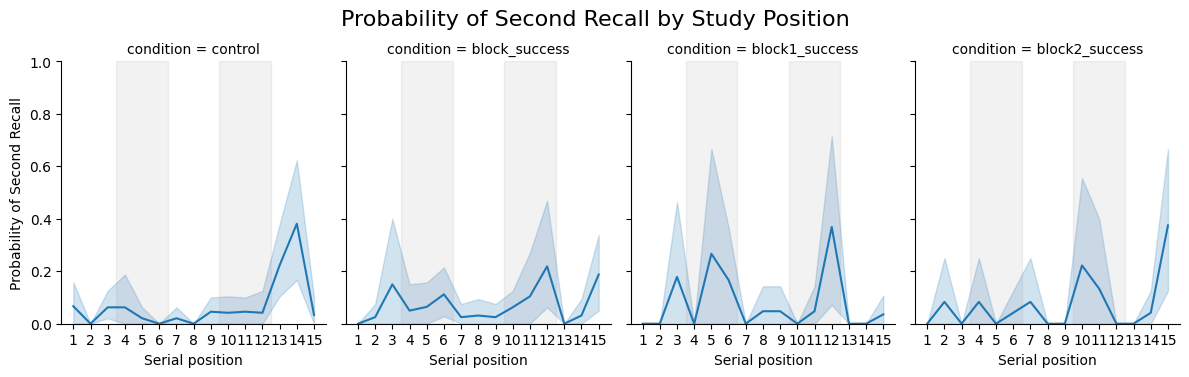

In [8]:
# %% P2R

# Limit to first recall
p2r = pnr.query("output == 2")

# Plotting
# g = fr.plot_spc(p2r)
# plt.ylim([0, 0.7])
# g = fr.plot_spc(p2r, col="subject", col_wrap=5)
# plt.ylim([0, 0.7])
g = fr.plot_spc(p2r, col="condition", col_wrap=4)

# set g size bigger
g.fig.set_size_inches(12, 4)

# show all 15 positions in xticks
plt.xticks(
    np.arange(1, 16),
    [str(i) for i in range(1, 16)],
)

g.set_ylabels("Probability of Second Recall")

# for each figure, draw vertical lines at 4, 6, 10, 12
for ax in g.axes.flat:
    ax.set_xticks(np.arange(1, 16))
    ax.set_xticklabels([str(i) for i in range(1, 16)])
    
    # Early block: positions 4 to 6
    ax.axvspan(3.5, 6.5, color="gray", alpha=0.1)  # extend slightly beyond edges
    
    # Late block: positions 10 to 12
    ax.axvspan(9.5, 12.5, color="gray", alpha=0.1)

g.fig.suptitle("Probability of Second Recall by Study Position", fontsize=16)

# Adjust layout to make space for the title
g.fig.subplots_adjust(top=0.85)

### Is overall lag-contiguity disrupted by our category cueing? (Yes)

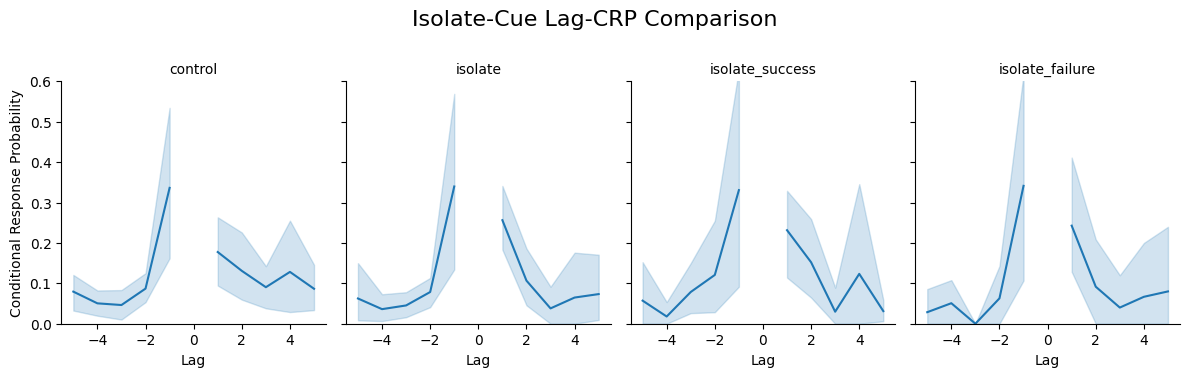

In [9]:
# %% Lag-CRP: Isolates-Focused

# Compute lag-CRP for control and isolate trial types (matching PFR setup)

crp_control = fr.lag_crp(data.query('cue_type == "control"'))

crp_isolate = fr.lag_crp(data.query('cue_type == "isolate"'))
crp_isolate_success = fr.lag_crp(data.query('cue_type == "isolate" and target_success == 1'))
crp_isolate_failure = fr.lag_crp(data.query('cue_type == "isolate" and target_success == 0'))

# Combine with condition labels
lag_crp = pd.concat([
    crp_control.assign(condition="control"),
    crp_isolate.assign(condition="isolate"),
    crp_isolate_success.assign(condition="isolate_success"),
    crp_isolate_failure.assign(condition="isolate_failure"),
])

# Plot: condition-level comparison (main figure)
g = fr.plot_lag_crp(lag_crp, col="condition", col_wrap=4)
g.fig.set_size_inches(12, 4)
plt.ylim([0, 0.6])
g.set_ylabels("Conditional Response Probability")
g.set_titles("{col_name}")

# Add an overall title
g.fig.suptitle("Isolate-Cue Lag-CRP Comparison", fontsize=16)
g.fig.subplots_adjust(top=0.80)

# Optional: subject-level grid
# g = fr.plot_lag_crp(lag_crp, col="subject", col_wrap=5)
# g.fig.set_size_inches(12, 8)
# plt.ylim([0, 0.6])
# g.fig.suptitle("Lag-CRP by Subject", fontsize=16)
# g.fig.subplots_adjust(top=0.9)

# lag_crp

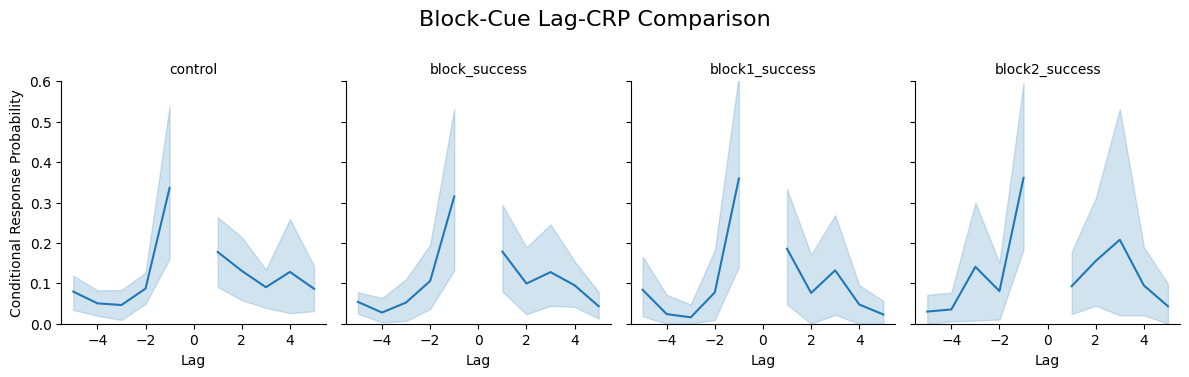

In [10]:
# %% Lag-CRP: Block-Cue Focused

crp_control = fr.lag_crp(data.query('cue_type == "control"'))
crp_block_success = fr.lag_crp(data.query('block_success_group > 0'))
crp_block1_success = fr.lag_crp(data.query('block_success_group == 1'))
crp_block2_success = fr.lag_crp(data.query('block_success_group == 2'))

# Combine with condition labels
lag_crp = pd.concat([
    crp_control.assign(condition="control"),
    crp_block_success.assign(condition="block_success"),
    crp_block1_success.assign(condition="block1_success"),
    crp_block2_success.assign(condition="block2_success"),
])


# Plot: condition-level comparison (main figure)
g = fr.plot_lag_crp(lag_crp, col="condition", col_wrap=4)
g.fig.set_size_inches(12, 4)
plt.ylim([0, 0.6])
g.set_ylabels("Conditional Response Probability")
g.set_titles("{col_name}")

# Add an overall title
g.fig.suptitle("Block-Cue Lag-CRP Comparison", fontsize=16)
g.fig.subplots_adjust(top=0.80)

# Optional: subject-level grid
# g = fr.plot_lag_crp(lag_crp, col="subject", col_wrap=5)
# g.fig.set_size_inches(12, 8)
# plt.ylim([0, 0.6])
# g.fig.suptitle("Lag-CRP by Subject", fontsize=16)
# g.fig.subplots_adjust(top=0.9)

# lag_crp

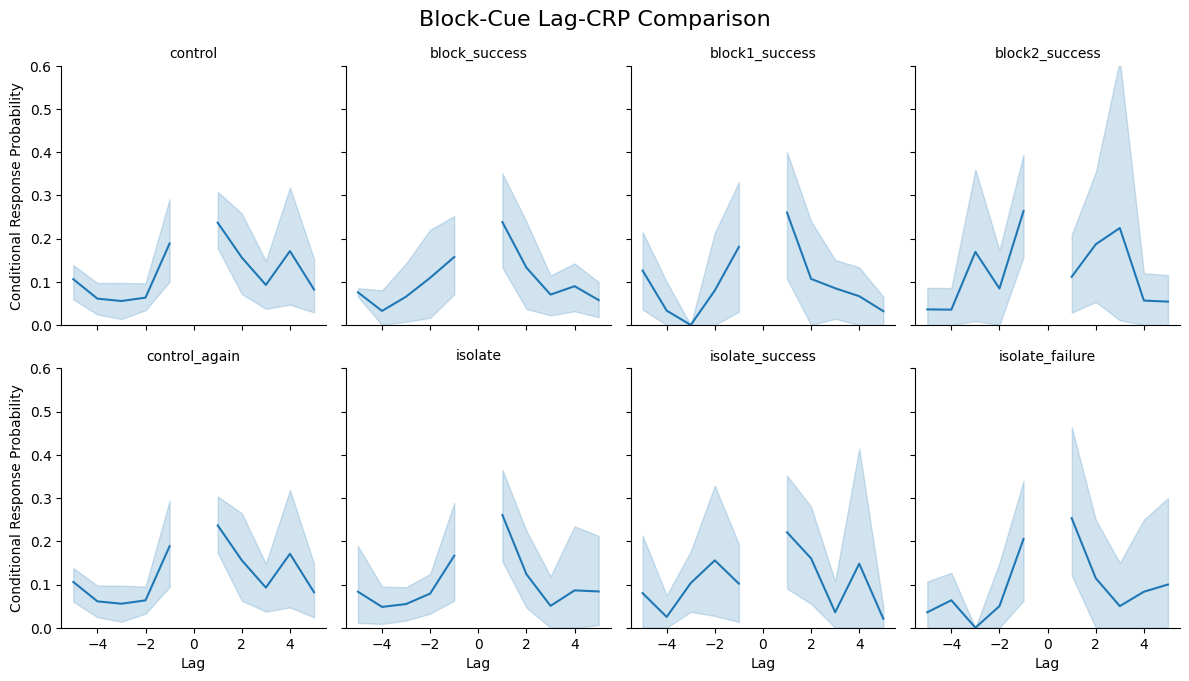

In [19]:
# %% Exclude subjects 0 and 5 to return some forward-assymetry

excluded_subjects = "subject != 0 and subject != 5"

crp_control = fr.lag_crp(data.query(f'cue_type == "control" and {excluded_subjects}'))
crp_block_success = fr.lag_crp(data.query(f'block_success_group > 0 and {excluded_subjects}'))
crp_block1_success = fr.lag_crp(data.query(f'block_success_group == 1 and {excluded_subjects}'))
crp_block2_success = fr.lag_crp(data.query(f'block_success_group == 2 and {excluded_subjects}'))

crp_control_again = fr.lag_crp(data.query(f'cue_type == "control" and {excluded_subjects}'))
crp_isolate = fr.lag_crp(data.query(f'cue_type == "isolate" and {excluded_subjects}'))
crp_isolate_success = fr.lag_crp(data.query(f'cue_type == "isolate" and target_success == 1 and {excluded_subjects}'))
crp_isolate_failure = fr.lag_crp(data.query(f'cue_type == "isolate" and target_success == 0 and {excluded_subjects}'))

# Combine with condition labels
lag_crp = pd.concat([
    crp_control.assign(condition="control"),
    crp_block_success.assign(condition="block_success"),
    crp_block1_success.assign(condition="block1_success"),
    crp_block2_success.assign(condition="block2_success"),
    crp_control_again.assign(condition="control_again"),
    crp_isolate.assign(condition="isolate"),
    crp_isolate_success.assign(condition="isolate_success"),
    crp_isolate_failure.assign(condition="isolate_failure"),
])


# Plot: condition-level comparison (main figure)
g = fr.plot_lag_crp(lag_crp, col="condition", col_wrap=4)
g.fig.set_size_inches(12, 7)
plt.ylim([0, 0.6])
g.set_ylabels("Conditional Response Probability")
g.set_titles("{col_name}")

# Add an overall title
g.fig.suptitle("Block-Cue Lag-CRP Comparison", fontsize=16)
g.fig.subplots_adjust(top=.9)

# Optional: subject-level grid
# g = fr.plot_lag_crp(lag_crp, col="subject", col_wrap=5)
# g.fig.set_size_inches(12, 8)
# plt.ylim([0, 0.6])
# g.fig.suptitle("Lag-CRP by Subject", fontsize=16)
# g.fig.subplots_adjust(top=0.9)

# lag_crp

In [11]:
# %% Lag-Rank Analysis (isolate-focused)

ranks_control = fr.lag_rank(data.query('cue_type == "control"'))
ranks_isolate = fr.lag_rank(data.query('cue_type == "isolate"'))
ranks_isolate_success = fr.lag_rank(data.query('cue_type == "isolate" and target_success == 1'))
ranks_isolate_failure = fr.lag_rank(data.query('cue_type == "isolate" and target_success == 0'))

ranks = pd.concat(
    [
        ranks_control.assign(condition="control"),
        ranks_isolate.assign(condition="isolate"),
        ranks_isolate_success.assign(condition="isolate_success"),
        ranks_isolate_failure.assign(condition="isolate_failure"),
    ]
)

print("control")
print(ranks_control.agg(["mean", "sem"])["rank"])
print("isolate")
print(ranks_isolate.agg(["mean", "sem"])["rank"])
print("isolate_success")
print(ranks_isolate_success.agg(["mean", "sem"])["rank"])
print("isolate_failure")
print(ranks_isolate_failure.agg(["mean", "sem"])["rank"])

ranks

control
mean    0.715887
sem     0.053766
Name: rank, dtype: float64
isolate
mean    0.720383
sem     0.055788
Name: rank, dtype: float64
isolate_success
mean    0.721623
sem     0.063639
Name: rank, dtype: float64
isolate_failure
mean    0.715020
sem     0.080711
Name: rank, dtype: float64


,subject,rank,condition
0,0,0.889097,control
1,1,0.596515,control
2,2,0.714489,control
3,3,0.499536,control
4,4,0.749167,control
5,5,0.953858,control
6,6,0.722733,control
7,7,0.601696,control
0,0,0.916403,isolate
1,1,0.528569,isolate


In [12]:
# %% Lag-Rank Analysis (block-focused)

ranks_control = fr.lag_rank(data.query('cue_type == "control"'))
ranks_block_success = fr.lag_rank(data.query('block_success_group > 0'))
ranks_block1_success = fr.lag_rank(data.query('block_success_group == 1'))
ranks_block2_success = fr.lag_rank(data.query('block_success_group == 2'))

ranks = pd.concat(
    [
        ranks_control.assign(condition="control"),
        ranks_block_success.assign(condition="block_success"),
        ranks_block1_success.assign(condition="block1_success"),
        ranks_block2_success.assign(condition="block2_success"),
    ]
)

print("control")
print(ranks_control.agg(["mean", "sem"])["rank"])
print("block_success")
print(ranks_block_success.agg(["mean", "sem"])["rank"])
print("block1_success")
print(ranks_block1_success.agg(["mean", "sem"])["rank"])
print("block2_success")
print(ranks_block2_success.agg(["mean", "sem"])["rank"])

ranks

control
mean    0.715887
sem     0.053766
Name: rank, dtype: float64
block_success
mean    0.702693
sem     0.049270
Name: rank, dtype: float64
block1_success
mean    0.696719
sem     0.056352
Name: rank, dtype: float64
block2_success
mean    0.741924
sem     0.071996
Name: rank, dtype: float64


,subject,rank,condition
0,0,0.889097,control
1,1,0.596515,control
2,2,0.714489,control
3,3,0.499536,control
4,4,0.749167,control
5,5,0.953858,control
6,6,0.722733,control
7,7,0.601696,control
0,0,0.938350,block_success
1,1,0.583126,block_success


In [14]:
# %% Lag-Rank Analysis (block-focused, excluding subjects 0 and 5)

excluded_subjects = "subject != 0 and subject != 5"

ranks_control = fr.lag_rank(data.query(f'cue_type == "control" and {excluded_subjects}'))
ranks_block_success = fr.lag_rank(data.query(f'block_success_group > 0 and {excluded_subjects}'))
ranks_block1_success = fr.lag_rank(data.query(f'block_success_group == 1 and {excluded_subjects}'))
ranks_block2_success = fr.lag_rank(data.query(f'block_success_group == 2 and {excluded_subjects}'))

ranks = pd.concat(
    [
        ranks_control.assign(condition="control"),
        ranks_block_success.assign(condition="block_success"),
        ranks_block1_success.assign(condition="block1_success"),
        ranks_block2_success.assign(condition="block2_success"),
    ]
)

print("control")
print(ranks_control.agg(["mean", "sem"])["rank"])
print("block_success")
print(ranks_block_success.agg(["mean", "sem"])["rank"])
print("block1_success")
print(ranks_block1_success.agg(["mean", "sem"])["rank"])
print("block2_success")
print(ranks_block2_success.agg(["mean", "sem"])["rank"])

ranks

control
mean    0.647356
sem     0.039612
Name: rank, dtype: float64
block_success
mean    0.637703
sem     0.032282
Name: rank, dtype: float64
block1_success
mean    0.622893
sem     0.042901
Name: rank, dtype: float64
block2_success
mean    0.700519
sem     0.072136
Name: rank, dtype: float64


,subject,rank,condition
0,1,0.596515,control
1,2,0.714489,control
2,3,0.499536,control
3,4,0.749167,control
4,6,0.722733,control
5,7,0.601696,control
0,1,0.583126,block_success
1,2,0.709887,block_success
2,3,0.569010,block_success
3,4,0.735885,block_success


## How Often Do Subjects Recall the Category Target?

In [20]:
# %% Focus on targetting trials, then aggregating target_success by subject
success_rates = data.query("condition > 0").pivot_table(
    index="subject", values="target_success", aggfunc="mean"
)

# mean and sem over subjects
print(success_rates.agg(["mean", "sem"])["target_success"])
success_rates

mean    0.669359
sem     0.124208
Name: target_success, dtype: float64


,target_success
subject,
0,1.000000
1,0.680851
2,0.107914
3,1.000000
4,0.555556
5,0.227941
6,1.000000
7,0.782609


In [22]:
# %% exclude those subjects again
success_rates = data.query(f"condition > 0 and {excluded_subjects}").pivot_table(
    index="subject", values="target_success", aggfunc="mean"
)

# mean and sem over subjects
print(success_rates.agg(["mean", "sem"])["target_success"])
success_rates

mean    0.687821
sem     0.136349
Name: target_success, dtype: float64


,target_success
subject,
1,0.680851
2,0.107914
3,1.000000
4,0.555556
6,1.000000
7,0.782609


## Focusing on Transitions From Category Targets

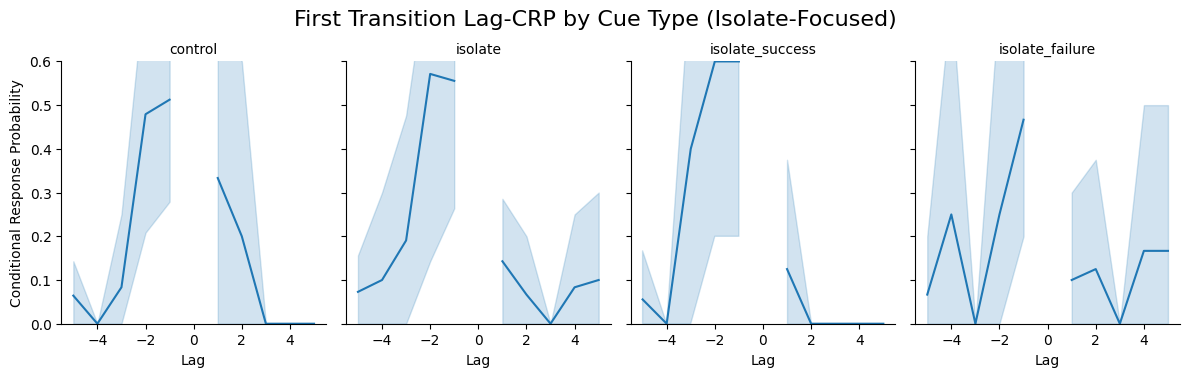

In [24]:
# %% First Transition Lag-CRP (isolate-focused)

item_filter = "output < 3 or not recall"

crp_control = fr.lag_crp(data.query('cue_type == "control"'), item_query=item_filter)
crp_isolate = fr.lag_crp(data.query('cue_type == "isolate"'), item_query=item_filter)
crp_isolate_success = fr.lag_crp(data.query('cue_type == "isolate" and target_success == 1'), item_query=item_filter)
crp_isolate_failure = fr.lag_crp(data.query('cue_type == "isolate" and target_success == 0'), item_query=item_filter)

lag_crp = pd.concat([
    crp_control.assign(condition="control"),
    crp_isolate.assign(condition="isolate"),
    crp_isolate_success.assign(condition="isolate_success"),
    crp_isolate_failure.assign(condition="isolate_failure"),
])

# Plot
g = fr.plot_lag_crp(lag_crp, col="condition", col_wrap=4)
g.fig.set_size_inches(12, 4)
plt.ylim([0, 0.6])
g.set_ylabels("Conditional Response Probability")
g.set_titles("{col_name}")
g.fig.suptitle("First Transition Lag-CRP by Cue Type (Isolate-Focused)", fontsize=16)
g.fig.subplots_adjust(top=0.85)

# lag_crp

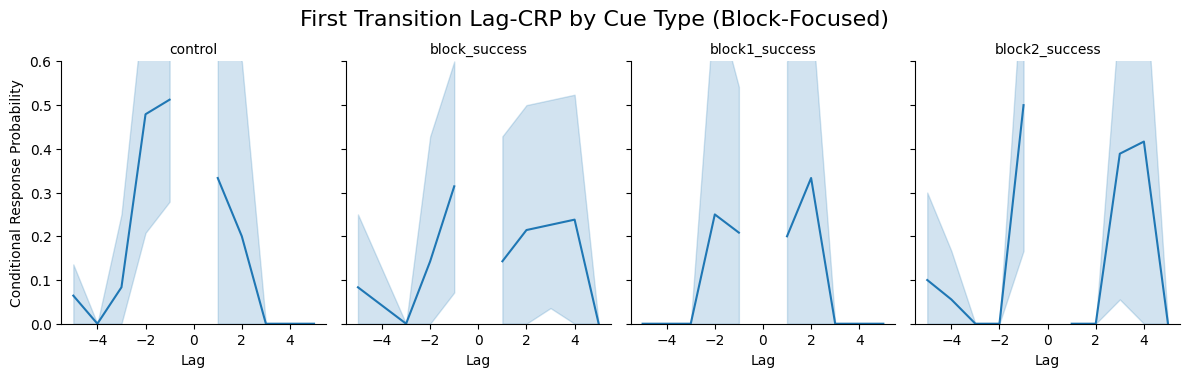

In [25]:
# %% First Transition Lag-CRP (block-focused)

item_filter = "output < 3 or not recall"

crp_control = fr.lag_crp(data.query('cue_type == "control"'), item_query=item_filter)
crp_block_success = fr.lag_crp(data.query('block_success_group > 0'), item_query=item_filter)
crp_block1_success = fr.lag_crp(data.query('block_success_group == 1'), item_query=item_filter)
crp_block2_success = fr.lag_crp(data.query('block_success_group == 2'), item_query=item_filter)

lag_crp = pd.concat([
    crp_control.assign(condition="control"),
    crp_block_success.assign(condition="block_success"),
    crp_block1_success.assign(condition="block1_success"),
    crp_block2_success.assign(condition="block2_success"),
])

# Plot
g = fr.plot_lag_crp(lag_crp, col="condition", col_wrap=4)
g.fig.set_size_inches(12, 4)
plt.ylim([0, 0.6])
g.set_ylabels("Conditional Response Probability")
g.set_titles("{col_name}")
g.fig.suptitle("First Transition Lag-CRP by Cue Type (Block-Focused)", fontsize=16)
g.fig.subplots_adjust(top=0.85)

# lag_crp

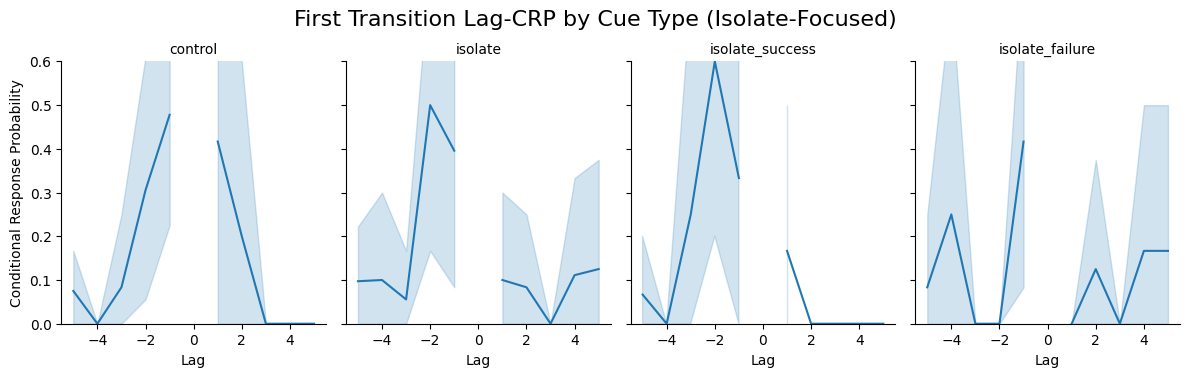

In [26]:
# %% First Transition Lag-CRP (isolate-focused) excluding subjects 0 and 5

item_filter = "output < 3 or not recall"

crp_control = fr.lag_crp(data.query(f'cue_type == "control" and {excluded_subjects}'), item_query=item_filter)
crp_isolate = fr.lag_crp(data.query(f'cue_type == "isolate" and {excluded_subjects}'), item_query=item_filter)
crp_isolate_success = fr.lag_crp(data.query(f'cue_type == "isolate" and target_success == 1 and {excluded_subjects}'), item_query=item_filter)
crp_isolate_failure = fr.lag_crp(data.query(f'cue_type == "isolate" and target_success == 0 and {excluded_subjects}'), item_query=item_filter)

lag_crp = pd.concat([
    crp_control.assign(condition="control"),
    crp_isolate.assign(condition="isolate"),
    crp_isolate_success.assign(condition="isolate_success"),
    crp_isolate_failure.assign(condition="isolate_failure"),
])

# Plot
g = fr.plot_lag_crp(lag_crp, col="condition", col_wrap=4)
g.fig.set_size_inches(12, 4)
plt.ylim([0, 0.6])
g.set_ylabels("Conditional Response Probability")
g.set_titles("{col_name}")
g.fig.suptitle("First Transition Lag-CRP by Cue Type (Isolate-Focused)", fontsize=16)
g.fig.subplots_adjust(top=0.85)

# lag_crp

### Excluding Transitions to First Item

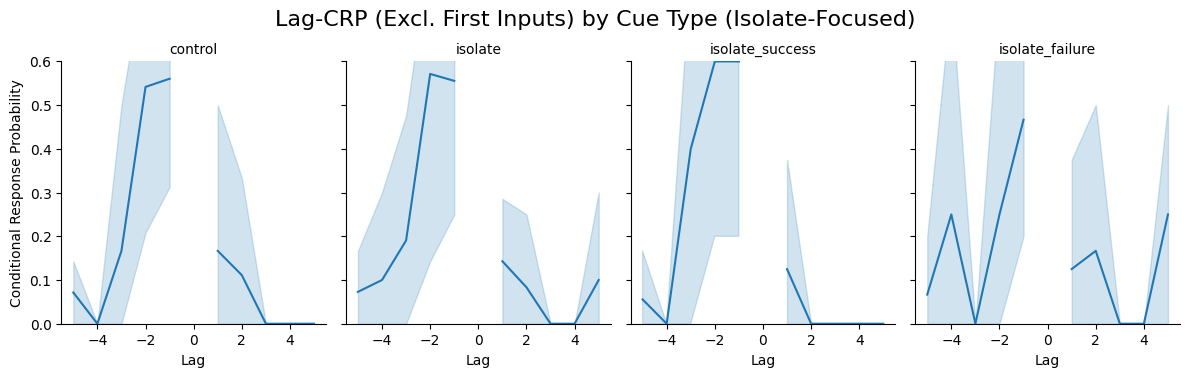

In [28]:
# %% Lag-CRP (exclude transitions to first input items — isolate-focused)

item_filter = "(output < 3 or not recall) and input > 2"

crp_control = fr.lag_crp(data.query('cue_type == "control"'), item_query=item_filter)
crp_isolate = fr.lag_crp(data.query('cue_type == "isolate"'), item_query=item_filter)
crp_isolate_success = fr.lag_crp(data.query('cue_type == "isolate" and target_success == 1'), item_query=item_filter)
crp_isolate_failure = fr.lag_crp(data.query('cue_type == "isolate" and target_success == 0'), item_query=item_filter)

lag_crp = pd.concat([
    crp_control.assign(condition="control"),
    crp_isolate.assign(condition="isolate"),
    crp_isolate_success.assign(condition="isolate_success"),
    crp_isolate_failure.assign(condition="isolate_failure"),
])

# Plot
g = fr.plot_lag_crp(lag_crp, col="condition", col_wrap=4)
g.fig.set_size_inches(12, 4)
plt.ylim([0, 0.6])
g.set_ylabels("Conditional Response Probability")
g.set_titles("{col_name}")
g.fig.suptitle("Lag-CRP (Excl. First Inputs) by Cue Type (Isolate-Focused)", fontsize=16)
g.fig.subplots_adjust(top=0.85)

# lag_crp

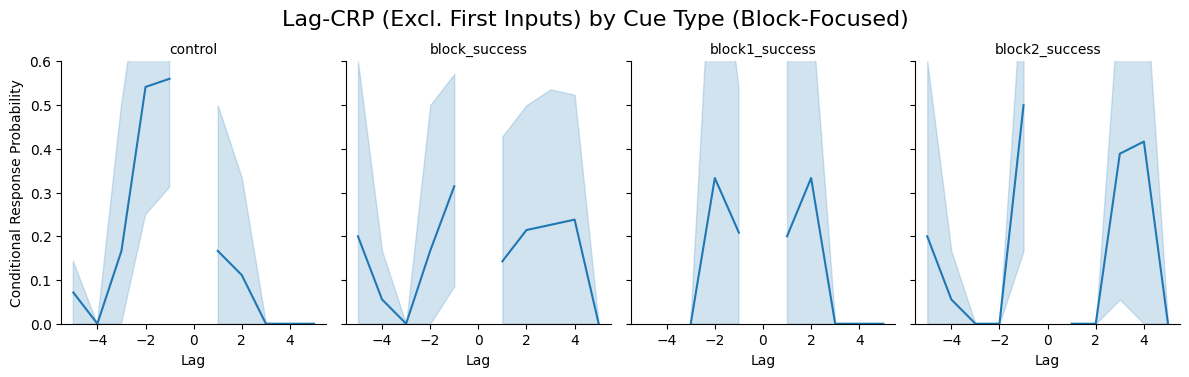

In [30]:
# %% Lag-CRP (exclude transitions to first input items — block-focused)

item_filter = "(output < 3 or not recall) and input > 2"

crp_control = fr.lag_crp(data.query('cue_type == "control"'), item_query=item_filter)
crp_block_success = fr.lag_crp(data.query('block_success_group > 0'), item_query=item_filter)
crp_block1_success = fr.lag_crp(data.query('block_success_group == 1'), item_query=item_filter)
crp_block2_success = fr.lag_crp(data.query('block_success_group == 2'), item_query=item_filter)

lag_crp = pd.concat([
    crp_control.assign(condition="control"),
    crp_block_success.assign(condition="block_success"),
    crp_block1_success.assign(condition="block1_success"),
    crp_block2_success.assign(condition="block2_success"),
])

# Plot
g = fr.plot_lag_crp(lag_crp, col="condition", col_wrap=4)
g.fig.set_size_inches(12, 4)
plt.ylim([0, 0.6])
g.set_ylabels("Conditional Response Probability")
g.set_titles("{col_name}")
g.fig.suptitle("Lag-CRP (Excl. First Inputs) by Cue Type (Block-Focused)", fontsize=16)
g.fig.subplots_adjust(top=0.85)

# lag_crp

### Exclude Transitions to Last Item

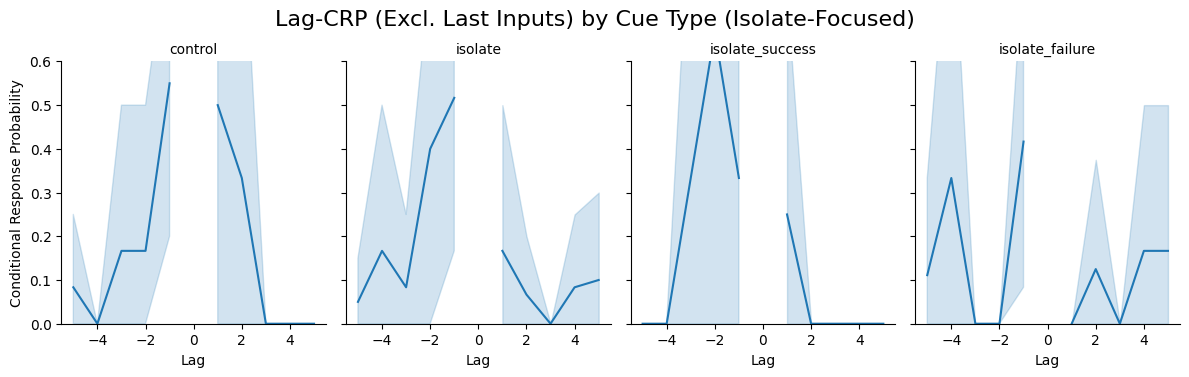

In [32]:
# %% Lag-CRP (exclude transitions to last input items — isolate-focused)

item_filter = "(output < 3 or not recall) and input < 15"

crp_control = fr.lag_crp(data.query('cue_type == "control"'), item_query=item_filter)
crp_isolate = fr.lag_crp(data.query('cue_type == "isolate"'), item_query=item_filter)
crp_isolate_success = fr.lag_crp(data.query('cue_type == "isolate" and target_success == 1'), item_query=item_filter)
crp_isolate_failure = fr.lag_crp(data.query('cue_type == "isolate" and target_success == 0'), item_query=item_filter)

lag_crp = pd.concat([
    crp_control.assign(condition="control"),
    crp_isolate.assign(condition="isolate"),
    crp_isolate_success.assign(condition="isolate_success"),
    crp_isolate_failure.assign(condition="isolate_failure"),
])

# Plot
g = fr.plot_lag_crp(lag_crp, col="condition", col_wrap=4)
g.fig.set_size_inches(12, 4)
plt.ylim([0, 0.6])
g.set_ylabels("Conditional Response Probability")
g.set_titles("{col_name}")
g.fig.suptitle("Lag-CRP (Excl. Last Inputs) by Cue Type (Isolate-Focused)", fontsize=16)
g.fig.subplots_adjust(top=0.85)

# lag_crp

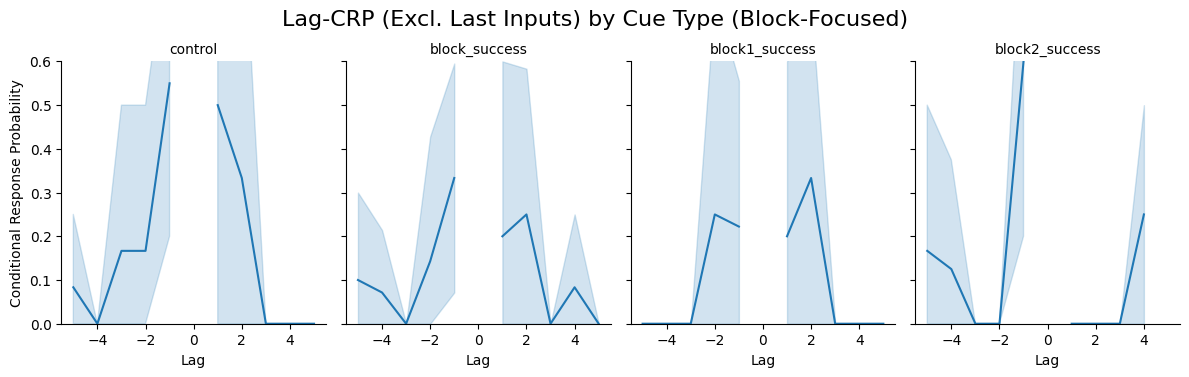

In [34]:
# %% Lag-CRP (exclude transitions to last input items — block-focused)

item_filter = "(output < 3 or not recall) and input < 15"

crp_control = fr.lag_crp(data.query('cue_type == "control"'), item_query=item_filter)
crp_block_success = fr.lag_crp(data.query('block_success_group > 0'), item_query=item_filter)
crp_block1_success = fr.lag_crp(data.query('block_success_group == 1'), item_query=item_filter)
crp_block2_success = fr.lag_crp(data.query('block_success_group == 2'), item_query=item_filter)

lag_crp = pd.concat([
    crp_control.assign(condition="control"),
    crp_block_success.assign(condition="block_success"),
    crp_block1_success.assign(condition="block1_success"),
    crp_block2_success.assign(condition="block2_success"),
])

# Plot
g = fr.plot_lag_crp(lag_crp, col="condition", col_wrap=4)
g.fig.set_size_inches(12, 4)
plt.ylim([0, 0.6])
g.set_ylabels("Conditional Response Probability")
g.set_titles("{col_name}")
g.fig.suptitle("Lag-CRP (Excl. Last Inputs) by Cue Type (Block-Focused)", fontsize=16)
g.fig.subplots_adjust(top=0.85)

# lag_crp

## ...

In [ ]:
# %% First Transition Lag-Rank

item_filter = "output < 3 or not recall"

ranks_control = fr.lag_rank(
    data.query(f'cue_type == "control"'), item_query=item_filter
)
ranks_block = fr.lag_rank(data.query(f'cue_type == "block"'), item_query=item_filter)
ranks_isolate = fr.lag_rank(
    data.query(f'cue_type == "isolate"'), item_query=item_filter
)

print("control")
print(ranks_control.agg(["mean", "sem"])["rank"])
print("block")
print(ranks_block.agg(["mean", "sem"])["rank"])
print("isolate")
print(ranks_isolate.agg(["mean", "sem"])["rank"])

ranks_block
ranks_control
ranks_isolate


control
mean    0.780038
sem     0.058056
Name: rank, dtype: float64
block
mean    0.612950
sem     0.065339
Name: rank, dtype: float64
isolate
mean    0.786296
sem     0.058796
Name: rank, dtype: float64


,subject,rank
0,0,0.975000
1,1,0.694444
2,2,0.526515
3,3,1.000000
4,4,0.645833
5,5,0.871429
6,6,0.720000
7,7,0.857143


## Modification: Ignore Transitions to First Item from Category Targets

,subject,lag,prob,actual,possible,condition
0,0,-14,NaN,0,0,control
1,0,-13,0.0,0,5,control
2,0,-12,0.0,0,5,control
3,0,-11,0.0,0,4,control
4,0,-10,0.0,0,1,control
...,...,...,...,...,...,...
140,7,10,NaN,0,0,failure
141,7,11,NaN,0,0,failure
142,7,12,NaN,0,0,failure
143,7,13,NaN,0,0,failure


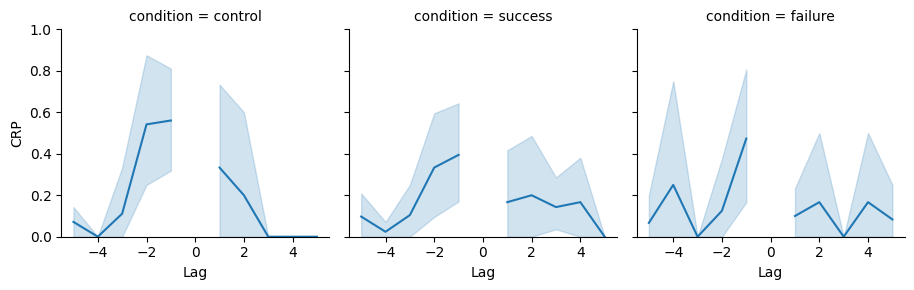

In [ ]:
crp_control = fr.lag_crp(
    data.query("condition == 0"),
    item_query="output < 3 or not recall",
    test_key="input",
    test=lambda x, y: y > 1,
)
crp_success = fr.lag_crp(
    data.query("condition == 2"),
    item_query="output < 3 or not recall",
    test_key="input",
    test=lambda x, y: y > 1,
)
crp_attempt = fr.lag_crp(
    data.query("condition == 1"),
    item_query="output < 3 or not recall",
    test_key="input",
    test=lambda x, y: y > 1,
)
lag_crp = pd.concat(
    [
        crp_control.assign(condition="control"),
        crp_success.assign(condition="success"),
        crp_attempt.assign(condition="failure"),
    ]
)

# g = fr.plot_lag_crp(lag_crp)
g = fr.plot_lag_crp(lag_crp, col="condition", col_wrap=5)
lag_crp

In [ ]:
# %% Lag-Rank (first transitions, excluding input 1, grouped by cue_type)

ranks_control = fr.lag_rank(
    data.query('cue_type == "control"'),
    item_query="output < 3 or not recall",
    test_key="input",
    test=lambda x, y: y > 1,
)

ranks_block = fr.lag_rank(
    data.query('cue_type == "block"'),
    item_query="output < 3 or not recall",
    test_key="input",
    test=lambda x, y: y > 1,
)

ranks_isolate = fr.lag_rank(
    data.query('cue_type == "isolate"'),
    item_query="output < 3 or not recall",
    test_key="input",
    test=lambda x, y: y > 1,
)

ranks = pd.concat(
    [
        ranks_control.assign(condition="control"),
        ranks_block.assign(condition="block"),
        ranks_isolate.assign(condition="isolate"),
    ]
)

# Print summary stats
print("control")
print(ranks_control.agg(["mean", "sem"])["rank"])
print("block")
print(ranks_block.agg(["mean", "sem"])["rank"])
print("isolate")
print(ranks_isolate.agg(["mean", "sem"])["rank"])

ranks_block


control
mean    0.836271
sem     0.059812
Name: rank, dtype: float64
block
mean    0.601596
sem     0.067160
Name: rank, dtype: float64
isolate
mean    0.773723
sem     0.063741
Name: rank, dtype: float64


,subject,rank
0,0,0.812500
1,1,0.341270
2,2,0.566667
3,3,0.370370
4,4,0.865714
5,5,0.718750
6,6,0.566667
7,7,0.570833


In [ ]:
# Looking at block transitions

block_trials = data.query(
    'cue_type == "block" and target_success == 1 and output <= 2 and recall'
)

# finding the first two outputs in block trials
block_first_two = block_trials[block_trials.output.isin([1, 2])]

# finding the transitions after successfully recalling a block cue
first_transitions = (
    block_first_two.pivot_table(
        index=["subject", "list"], columns="output", values="input"
    )
    .reset_index()
    .rename(columns={1: "first_input", 2: "second_input"})
)


# look at transitions and determine whether it was within its own block, between blocks, or outside of blocks
def classify_transition(first, second):
    block1 = range(4, 7)
    block2 = range(10, 13)
    if first in block1 and second in block1:
        return "within_block1"
    elif first in block2 and second in block2:
        return "within_block2"
    elif first in block1 and second in block2:
        return "between_blocks"
    elif first in block2 and second in block1:
        return "between_blocks"
    elif pd.isna(first) or pd.isna(second):
        return "incomplete"
    else:
        return "outside_block"


first_transitions["transition_type"] = first_transitions.apply(
    lambda row: classify_transition(row["first_input"], row["second_input"]), axis=1
)

In [ ]:
pd.pivot_table(data, index=["subject"], columns="output", values="input").values.shape

(8, 14)

In [ ]:
first_transitions

output,subject,list,first_input,second_input,transition_type
0,0,1,11.0,15.0,outside_block
1,0,4,12.0,12.0,within_block2
2,0,7,12.0,11.0,within_block2
3,0,14,12.0,15.0,outside_block
4,0,15,6.0,5.0,within_block1
5,1,2,10.0,2.0,outside_block
6,1,11,4.0,6.0,within_block1
7,1,12,12.0,7.0,outside_block
8,1,13,5.0,5.0,within_block1
9,1,15,4.0,12.0,between_blocks


Text(0, 0.5, 'Count')

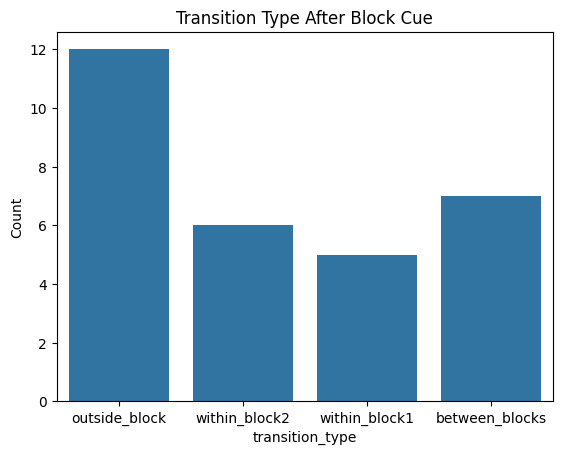

In [ ]:
# count up each type of transition
first_transitions["transition_type"].value_counts(normalize=True)

sns.countplot(data=first_transitions, x="transition_type")
plt.title("Transition Type After Block Cue")
plt.ylabel("Count")